**Neural Information Processing Systems (NIPS)** is a multi-track machine learning and computational neuroscience conference that includes invited talks, demonstrations, symposia and oral and poster presentations of refereed papers. 

I've been longing to start my research in AI - specifically in the cusp of machine learning and computational/ systems neuroscience, which is exactly the field that NIPS plays in. Availability of this dataset is a blessing, because I can now better understand 
- who are the players contributing to cutting-edge research in this area within the Australian research community,
- which unis are doing more than the others, 
- who are the up-and-comers versus the long-timers, 
- which pairs of researchers are the biggest collaborators,
- which areas are they playing in, and how has it been changing over the years
- which benchmark datasets have they been using mostly


Am fully cognisant of the fact that this view is pretty myopic. For starters, there are other conferences such as ICML etc, other journal publications which may not get featured or accepted into NIPS, or perhaps may involve private research that may not be amenable to publishing. However, this analysis can certainly be used directionally, I think haha. 

I've downloaded the data from the Kaggle NIPS dataset uploaded by Ben Hamner here (https://github.com/benhamner/nips-papers).  

## Admin stuff

In [1]:
import sqlite3
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(style="darkgrid")
import pandas as pd
import numpy as np

from datetime import datetime

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%reload_ext autoreload

C:\Users\M042266\.conda\envs\nips_papers_analysis\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# python-dotenv to load up all the entries in this file as environment variables so they are accessible with os.environ.get.
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# find root directory path
project_root_path = os.path.dirname(find_dotenv())

In [3]:
# creating a path for DATA directory
data_dir = os.path.join(project_root_path, 'DATA')

## Create input dataframe for specific country

The function below was created by doing some exploratory analysis in 00_\*.ipynb

In [4]:
# function for filtering and transforming country specific papers and authors
def nips_filter_country_specific(country_name):
    '''
    PURPOSE
    *******
    BLAH
    
    ARGUMENTS
    *********
    country_name: please enter specific string denoting the name of the country you want to filter your dataset
                  ex: 'Australia'
    
    REQUIRES
    ********
    DATA TO BE DOWNLOADED AND STORED INTO AN SQLITE DATABASE USING BEN HAMNER'S SCRIPT. CHECK SCRIPTS FOLDER
    pip install python-dotenv
    import os
    import pandas as pd
    from pandas import ExcelWriter
    
    RETURNS
    *******
    1) blah
    
    TO DO
    *****
    need to do error checking
    '''
    
    # create a database connection
    database_path = os.path.join(data_dir, 'database.sqlite')
    cnx = sqlite3.connect(database_path)
    
    # download the raw datasets for author, paper, relationship key
    df_papers = pd.read_sql("Select * from papers;", cnx)
    df_authors = pd.read_sql("Select * from authors;", cnx)
    df_key = pd.read_sql("Select * from paper_authors;", cnx)
    
    # create a feature for paper length
    df_papers['paper_length'] = df_papers['paper_text'].str.split().apply(len)
    
    # get the first 500 words of the paper text and store it in a new variable "paper_text_500_words"
    df_papers['paper_text_500_words'] = df_papers['paper_text'].apply(lambda x: ' '.join(x.split()[:500]))
    
    # mark the number of papers likely to be published by authors from the country specified by the user
    df_papers['country_paper'] = np.where(df_papers['paper_text_500_words'].str.contains(country_name),country_name,0)
    
    # bring in authors by merging papers with authors using the key table
    df_country = pd.merge(left=df_papers[df_papers.country_paper == country_name], right=df_key, left_on='id', right_on='paper_id',suffixes=('_papers', '_key'))
    df_country = pd.merge(left = df_country, right = df_authors, how='left',left_on='author_id', right_on='id',suffixes=('_country', '_author'))

    df_country.drop(['id_papers','event_type','abstract','id_key','paper_id','author_id','id'], axis = 1, inplace = True)

    # close the connection
    cnx.close()
    
    return df_papers, df_authors, df_country

In [5]:
df_papers, df_authors, df_ozzie = nips_filter_country_specific('Australia')

## Some exploratory analysis

In [6]:
country_name = 'Australia'

## Some general exploration on the dataset

#### How has NIPS popularity been growing both within the country of interest and outside?

(None, None)

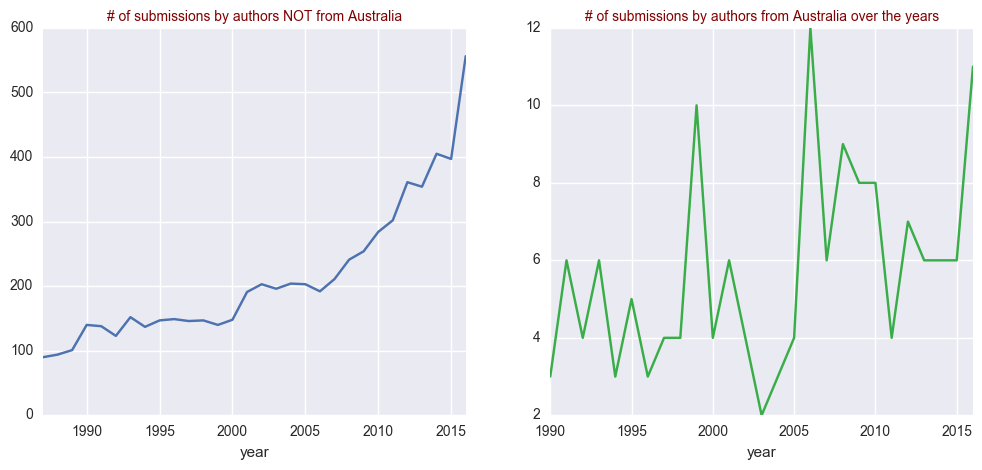

In [7]:
# set common parameters
fig = plt.figure(figsize=(12,5));   
sns.set_color_codes("muted")

# start painting!
ax0 = fig.add_subplot(1,2,1);
ax1 = fig.add_subplot(1,2,2);

df_papers.loc[df_papers.country_paper != country_name,['title','year']].groupby(by='year').count().plot(kind="line", ax = ax0)
df_papers.loc[df_papers.country_paper == country_name,['title','year']].groupby(by='year').count().plot(kind="line", ax = ax1, color = sns.xkcd_rgb["medium green"])

ax0.set_title("# of submissions by authors NOT from "+country_name,fontsize=10,color="maroon")
ax1.set_title("# of submissions by authors from "+country_name+" over the years",fontsize=10,color="maroon")
ax0.legend_.remove(), ax1.legend_.remove()

I thought it'd be better to put these 2 side by side, rather than as 2 lines in the same plot because the axes would be all messed up and we wouldnt get a true picture of the trends.

#### whats the deal with the event type?

I found a link on reddit here (https://www.reddit.com/r/MachineLearning/comments/3thfgz/nips/cx67pjt/) that tells us more about NIPS event types:<br>
Tutorials are multi-track, you generally pick one per time slot. These are, at their best, opinionated introductions to a particular area of inquiry; at their worst, a particular speaker's research highlights reel.<br>
The conference oral presentations are single track, there are no oral presentations scheduled at the same time as one another. There are "spotlight" sessions which are several 5 minute presentations back to back in roughly the same length of slot that one oral presentation would get. The poster sessions are one big, loud, overcrowded science fair type thing held in the evenings of the main conference.<br>
The workshops are more niche meetings that are scheduled separately and in parallel. Many people come just for the workshops, or rather for a particular workshop related to their area of interest; this applies to a lot of neuroscience folks who have long since abandoned the main conference (ironically given the first word of the name).

In [9]:
df_papers[df_papers.country_paper == country_name].event_type.value_counts()

             125
Poster        23
Spotlight      5
Oral           1
Name: event_type, dtype: int64

Most of them are unclassified. So I wouldnt read too much into this just yet.

#### how big are the papers?

[]

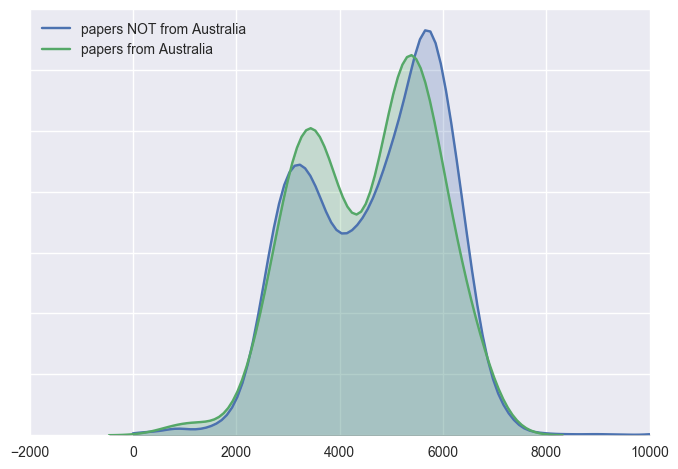

In [12]:
fig, ax = plt.subplots()
sns.kdeplot(df_papers.loc[df_papers.country_paper != country_name,'paper_length'], shade=True, ax = ax, clip=(0,10000))
sns.kdeplot(df_papers.loc[df_papers.country_paper == country_name,'paper_length'], shade=True, ax = ax)
ax.legend(labels=['papers NOT from '+country_name,'papers from '+country_name,], loc = 'best')
ax.yaxis.set_ticklabels([])

Looks like Ozzie papers are comparable to papers from around the world, being only slightly smaller.

## Have a look at the aussie authors

In [15]:
df_ozzie['name'].value_counts().head()

Alex J. Smola           28
Robert C. Williamson    15
Peter L. Bartlett       12
Tib?rio S. Caetano       8
S.v.n. Vishwanathan      8
Name: name, dtype: int64

Alex J. Smola (ex ANU and NICTA currently CMU), Robert C. Williamson(ANU, NICTA and Data61), and Peter L. Bartlett(ex ANU no Berkeley) have been killing it in the publications biz. Let's see who's been publishing more recently.

In [34]:
# number of research contributors to NIPS since 2010
df_ozzie.loc[df_ozzie.year > 2010,'name'].count()

122

In [17]:
df_ozzie.loc[df_ozzie.year > 2010,'name'].value_counts().head()

Justin Domke          5
Mark D. Reid          4
Xinhua Zhang          4
Tib?rio S. Caetano    3
Aaron Defazio         3
Name: name, dtype: int64

The story changes here. Justin Domke, Mark D. Reid, et al from ANU have been publishing industriously. Hang on, isnt Tiberio Caetano the founder of Ambiata? It'd be good to get a sense of every author's uni associations.

In [18]:
# display a larger string
pd.options.display.max_colwidth = 100

Here's 2 papers to check:<br>
1) Direct memory access using two cues: Finding the intersection of sets in a connectionist model -- by University of Queensland <br>
2) Comparison of three classification techniques,CART, C4.5 and Multi-Layer Perceptrons  -- by University of Queensland and Australian Defence Force Academy<br>

In [19]:
#df_ozzie[df_ozzie.title.str.contains('Comparison of three classification')].iloc[1,3]

Thats a bust because I cant see any way in which I can readily extract university or affiliation information from the text. I've also been checking online if there is an association register for NIPS. Lets see what comes up.

#### who are the players contributing to cutting-edge research in this area within the Australian research community

There's roughly 122 people in AI in Australia. In order to find out who to work with, I could literally send each of them emails. But learning about 100+ people, reading about their work and reaching out to them is crazy. I might as well do my PhD on my own! Need to be smarter about it.

I think the best thing I can do is to manually pick Australian universities and ML groups, and check whether the researcher is from any of the known associations. If not, raise a flag and manually check the guy.

Data61,<br>
Australian National University,<br>
University of Sydney,<br>
University of Adelaide,<br>
Deakin University,<br>
University of New South Wales,<br>
NICTA,<br>
University of Technology Sydney,<br>
Curtin University of Technology,<br>

This has by far been the most painful part of the process. I wish we had an avenue to looking up university, research group association of a presenter / publisher.

In [ ]:
# create a list of unis that you want to build a one-hot encoder for. When you refactor this, it can be a user input
list_of_unis = ['Data61','Australian National University','University of Sydney','University of Adelaide',
                'Deakin University','University of New South Wales','NICTA','University of Technology Sydney',
                'University of Queensland','Curtin University of Technology','National ICT Australia',
                'Sydney University','UNSW','University of Melbourne','Univ. of Sydney','University of Newcastle','CSIRO']

In [ ]:
# build a new dataframe df_ozzie_papers because we now want to investigate without authors - just the affiliations
df_ozzie_papers = df_papers[df_papers.ozzie == 1]

In [ ]:
# start building one-hot encoders for each known aussie university.
df_ozzie_papers['affiliation'] = ''
for uni in list_of_unis:
    df_ozzie_papers[uni] = df_ozzie_papers.paper_text_500_words.str.contains(uni)
    df_ozzie_papers['affiliation'] = np.where(df_ozzie_papers.paper_text_500_words.str.contains(uni),uni,df_ozzie_papers['affiliation'])

Have I missed any papers?

In [ ]:
df_ozzie_papers[df_ozzie_papers.loc[:,'Data61':].sum(axis=1)<1]['title']

Yep there are a few stragglers, but it seems like i've gotten most of them. Take care to aggregate some of the names here - example, Univ. of Sydney and University of Sydney.

In [ ]:
# data cleansing de-duplication (sum up the duplicates and remove the repeats)
# note: doing logical ORs. cool huh.
df_ozzie_papers['University of Sydney']|= df_ozzie_papers['Sydney University'] | df_ozzie_papers['Univ. of Sydney']
df_ozzie_papers['University of New South Wales']|= df_ozzie_papers['UNSW']
df_ozzie_papers['NICTA']|= df_ozzie_papers['National ICT Australia']
df_ozzie_papers.drop(['Sydney University','Univ. of Sydney','UNSW','National ICT Australia'],axis=1,inplace = True)

### Take a look at uni contributions over time 

In [ ]:
# start painting!
g = sns.factorplot(x="year", y= 'title', hue="affiliation", data=df_ozzie_timeseries, kind='point', size=4, aspect=2)
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)  
g.set_xticklabels(rotation=45)

Not very informative haha!

In [ ]:
cols = list(df_ozzie_papers.loc[:,'Data61':]) + ['year']
df_ozzie_papers[cols].groupby(by='year').sum()[['Australian National University','University of New South Wales', 'University of Sydney', 'NICTA', 'Data61']].plot()

It's not pretty, but NICTA is THE research group to be in Australia, if you're serious about AI and neural nets. ANU has a far stronger output than Usyd and UNSW, but Usyd seems to be doing marginally better than UNSW. Could that be because UNSW researchers might be associated to NICTA? If so, why has this association not impacted ANU badly? 

## Close the connection

In [ ]:
cnx.close()

FIN.